# Softmax Regression Implementation from Scratch
:label:`sec_softmax_scratch`

Because softmax regression is so fundamental,
we believe that you ought to know
how to implement it yourself.
Here, we limit ourselves to defining the
softmax-specific aspects of the model
and reuse the other components
from our linear regression section,
including the training loop.


In [141]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import jax
import jax.numpy as jnp
import optax
from flax import nnx

In [142]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [143]:
x_train = x_train / 255.
y_train = y_train.astype(np.int32)

In [144]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))

In [145]:
train_data.cardinality().numpy()

60000

In [146]:
n_epoch = 20
batch_size = 64
train_data = train_data.repeat(n_epoch).shuffle(buffer_size=500)
train_data = train_data.batch(batch_size, drop_remainder=True).prefetch(1)

In [147]:
train_data.cardinality().numpy() # (48000 * n_epoch) / batch_size

18750

In [148]:
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [149]:
def normalize_img(X, y):
  X = tf.cast(X, tf.float32) / 255.
  y = tf.cast(y, tf.int32)
  return X, y

test_data = test_data.map(normalize_img)

In [150]:
test_data = test_data.shuffle(500) 
test_data = test_data.batch(batch_size, drop_remainder=True).prefetch(1)

In [151]:
class SoftReg(nnx.Module):
	def __init__(self, rngs: nnx.Rngs):
		self.net = nnx.Linear(784, 10, rngs=rngs)
	
	def __call__(self, x: jax.Array):
		x = x.reshape((-1, 784))
		return self.net(x)

In [152]:
train_data.element_spec

(TensorSpec(shape=(64, 28, 28), dtype=tf.float64, name=None),
 TensorSpec(shape=(64,), dtype=tf.int32, name=None))

In [153]:
model = SoftReg(rngs=nnx.Rngs(params=0))

In [154]:
def loss_fn(model, batch):
  x, y = batch
  logits = model(x)
  loss = optax.softmax_cross_entropy_with_integer_labels(
    logits=logits, labels=y).mean()
  return loss, logits

In [155]:
optimizer = nnx.Optimizer(model, optax.adam(learning_rate=0.1))

In [156]:
nnx.display(optimizer)

Optimizer(
  step=OptState(
    value=Array(0, dtype=uint32)
  ),
  model=SoftReg(
    net=Linear(
      kernel=Param(
        value=Array(shape=(784, 10), dtype=float32)
      ),
      bias=Param(
        value=Array(shape=(10,), dtype=float32)
      ),
      in_features=784,
      out_features=10,
      use_bias=True,
      dtype=None,
      param_dtype=<class 'jax.numpy.float32'>,
      precision=None,
      kernel_init=<function variance_scaling.<locals>.init at 0x1748e6980>,
      bias_init=<function zeros at 0x15a0e79c0>,
      dot_general=<function dot_general at 0x15948af20>
    )
  ),
  tx=GradientTransformationExtraArgs(init=<function chain.<locals>.init_fn at 0x17a07c360>, update=<function chain.<locals>.update_fn at 0x17a07c5e0>),
  opt_state=(ScaleByAdamState(count=Array(0, dtype=int32), mu=State({
    'net': {
      'bias': VariableState(
        type=Param,
        value=Array(shape=(10,), dtype=float32)
      ),
      'kernel': VariableState(
        type=Param,
       

In [157]:
metrics = nnx.MultiMetric(
  accuracy=nnx.metrics.Accuracy(),
  loss=nnx.metrics.Average('loss'),
)

In [158]:
@nnx.jit
def train_step(model, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
  """Train for a single step."""
  grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grads = grad_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch[1])
  optimizer.update(grads)

In [159]:
@nnx.jit
def eval_step(model, metrics: nnx.MultiMetric, batch):
  loss, logits = loss_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch[1])

In [160]:
eval_every = 250

metrics_history = {
  'train_loss': [],
  'train_accuracy': [],
  'test_loss': [],
  'test_accuracy': [],
}

for step, batch in enumerate(train_data.as_numpy_iterator()):
  train_step(model, optimizer, metrics, batch)
  
  if step > 0 and (step % eval_every == 0): 
    for metric, value in metrics.compute().items():
      metrics_history[f'train_{metric}'].append(value)
    metrics.reset()

    for test_batch in test_data.as_numpy_iterator():
      eval_step(model, metrics, test_batch)

    for metric, value in metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)
    metrics.reset()

2024-10-20 10:04:26.480327: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-20 10:04:26.806566: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-20 10:04:27.130278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-20 10:04:27.456575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-20 10:04:27.782893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-20 10:04:28.107957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-20 10:04:28.431376: W tensorflow/core/framework/local_rendezvous.cc:404] L

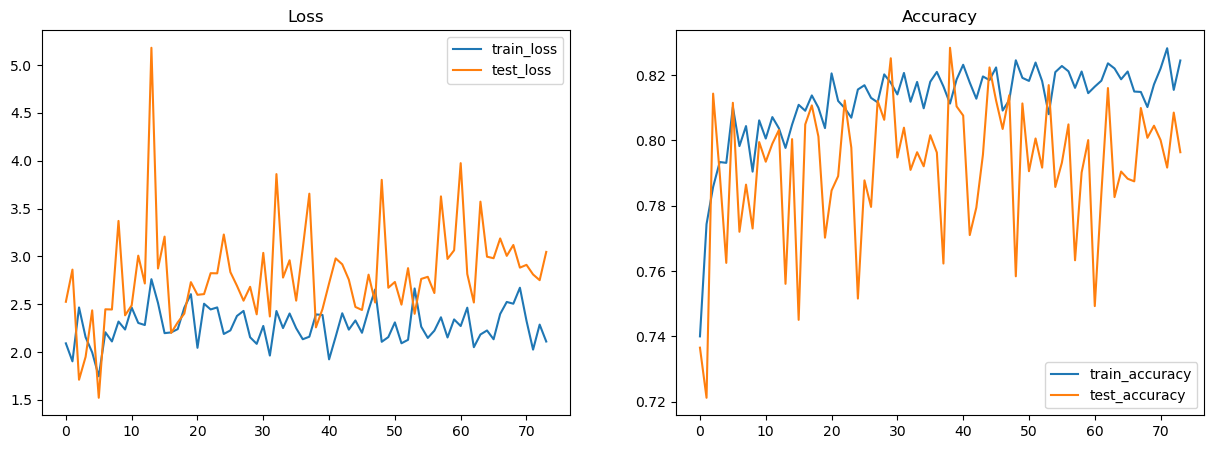

In [161]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train', 'test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()